In [5]:
# load environment variables
import dotenv
import os
dotenv.load_dotenv()
from svaeva_redux.schemas.redis import UserModel
user = UserModel.get("6070074875")
print(os.environ["REDIS_HOST"])
print(os.environ["REDIS_OM_URL"])
%matplotlib inline

127.0.0.1 # redis-stack
redis://127.0.0.1:6379/0


## Simulate a conversation between a Human-bot and the Information Forager and compute coversation embedding vectors

#### Run ```python evaluation/simulation/consonancia.py```

## Gather all users from that simulation!

In [4]:
# platform_id = "svaeva-redux"
# group_id = "consonancia"
# conversation_id = "sim-consonancia"
import os
platform_id = os.getenv("PLATFORM_ID")
group_id = os.getenv("GROUP_ID")
conversation_id = os.getenv("CONVERSATION_ID")
interaction_count = int(os.getenv("INTERACTION_COUNT", -1))

count = 0
users = UserModel.find(
    (UserModel.group_id == group_id)
    & (UserModel.platform_id == platform_id)
    & (UserModel.interaction_count >= count)
).all()

print("Number of users: ", len(users)) # 30 expected from simulation
key_prefix = f"{platform_id}_{conversation_id}:"
conditions = ["disc_hernia", "arthritis", "chronic_hip_pain", "pots", "breakup"]

ConnectionError: Error 8 connecting to 127.0.0.1 # redis-stack:6379. nodename nor servname provided, or not known.

## Calculate distances between conversations/users

In [106]:
import numpy as np
from typing import List, Dict, Union

def calculate_distances(nodes: List[dict], distance_metric: str = "euclidean") -> List[dict]:
    """Calculate distances between nodes.

    Args:
        nodes: List[dict]. A list of nodes. Each node is a dictionary with the following keys:
            - "id": str. A unique identifier for the node.
            - "cluster_id": int. A cluster identifier for the node.
            - "embedding": np.ndarray. An embedding vector for the node.
        distance_metric: str. A distance metric to use. It can be "euclidean" or "cosine".

    Returns:
        distances: List[dict]. A list of distances. Each element is a dictionary with the following keys:
            - "id": str. A cluster identifier for the node.
            - "distance": dict. A dictionary of distances to other nodes. The key is the node id and the value is the distance.
    """
    distances = []
    for node_x in nodes:
        vector_x = node_x["embedding"]
        current_id = node_x["id"]
        distance_info = {"id": current_id, "distance": {}, "cluster_id": node_x["cluster_id"]}
        for node_y in nodes:
            if node_x["id"] == node_y["id"]:
                continue
            vector_y = node_y["embedding"]
            other_id = node_y["id"]

            if distance_metric == "euclidean":
                distance = np.linalg.norm(vector_x - vector_y)
            elif distance_metric == "cosine":
                distance = 1 - np.dot(vector_x, vector_y) / (np.linalg.norm(vector_x) * np.linalg.norm(vector_y))

            distance_info["distance"][str(other_id)] = distance
        distances.append(distance_info)

    return distances

def calculate_distances_between_users(users: UserModel, cluster_ids: Union[Dict[str, int], None] = None):
    """Calculate distances between users. 
    
    Args:
        users: List[UserModel]. A list of UserModel objects.
        cluster_ids: Dict[str, int]. A dictionary of cluster ids. The key is the user id and the value is the cluster id.
    
    Returns:
        distances: List[dict]. A list of distances. Each element is a dictionary with the following keys:
            - "id": str. A cluster identifier for the node.
            - "distance": dict. A dictionary of distances to other nodes. The key is the node id and the value is the distance.
    """
    nodes = []
    for user in users:
        if cluster_ids is not None:
            cluster_id = cluster_ids[user.id]
        else:
            cluster_id = 0
        nodes.append({"id": user.id, "embedding": np.array(user.conversation_embedding), "cluster_id": cluster_id})

    distances = calculate_distances(nodes)

    return distances



In [190]:
distances = calculate_distances_between_users(users)

## Visualize embeddings using tSNE

In [3]:
import io
from PIL import Image
import base64
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [6]:

RANDOM_SEED = 42

def transform_tSNE(arr: np.ndarray, n_components: int, perplexity: int) -> np.ndarray:
    """Transform the given ndarray using a tSNE model.

    Args:
        arr: np.ndarray. In this example, an embedding matrix (n by m), where n is the number of examples and m equals to the embedding dimension.
        n_components: int. The number of components for tSNE.
        perplexity: int. Perplexity for tSNE.

    Returns:
        vis_dims: np.ndarray. A transformed matrix of n by n_components.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=RANDOM_SEED, init="random", learning_rate=200)
    vis_dims = tsne.fit_transform(arr)
    return vis_dims




def plot_embeddings(
    embed_arr_ls: List[np.ndarray], n_components: int, names: List[str], perplexity: int
):
    """Plot transformed embedding vectors with predefined labels.

    Args:
        embed_arr_ls: a list of np.ndarray. Each np.ndarray is a matrix with embeddings corresponding to data examples.
        n_components: int. The number of components for tSNE.
        names: a list of str. The names of the data sources. The length of this list should be the same as the length of embed_arr_ls.
        perplexity: int. Perplexity for tSNE.
        save_path: path to save figure
    Returns:
        None
    """
    vis_dims = transform_tSNE(np.concatenate(embed_arr_ls), n_components, perplexity)
    colors = ["red", "blue", "green", "orange", "purple"]
    list_names_set = list(set(names))
    colormap = matplotlib.colors.ListedColormap(colors)
    color_indices = []
    # for label in range(len(embed_arr_ls)):
    for label in names:
        color_indices += [list_names_set.index(label)]  # [label] * len(embed_arr_ls[label])
    assert len(vis_dims) == len(color_indices)
    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
    # for label in range(len(embed_arr_ls)):
    for color_index in range(len(colors)):
        # color = colors[label]
        color = colors[color_index]
        label_indices = [i for i, value in enumerate(color_indices) if value == color_index]
        avg_x = np.array(x)[label_indices].mean()
        avg_y = np.array(y)[label_indices].mean()
        ax.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=list_names_set[color_index])

    ax.legend()
    plt.title("Conversations sample data visualized in language using t-SNE")
    return fig

NameError: name 'List' is not defined

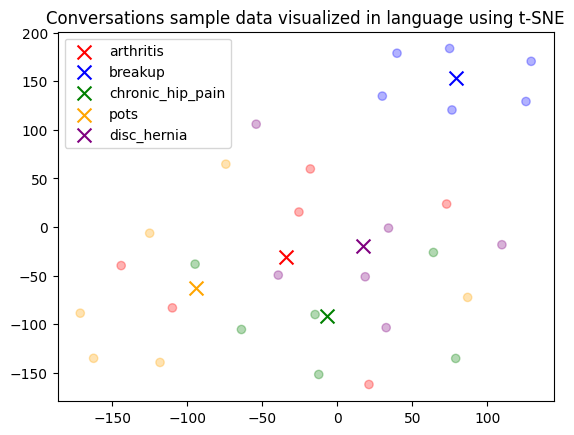

In [192]:
embeddings = [np.array(user.conversation_embedding).reshape(1, -1) for user in users]
names = []
for user in users:
    parts = user.id.split("-")
    name = parts[2]
    names.append(name)
fig = plot_embeddings(embeddings, 2, names, 15)

/var/folders/tb/xg4c2c4n3hgfyrtz0t73jls40000gn/T/ipykernel_31807/2923195219.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, zs=z, zdir="z", c=color, label=cat)


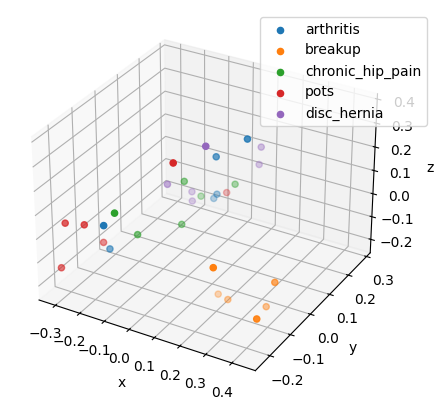

In [193]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)


# make in matrix
matrix = np.array([np.array(user.conversation_embedding) for user in users])
vis_dims = pca.fit_transform(matrix)
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np



def plot_

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection="3d")
cmap = plt.get_cmap("tab10")

# Plot each sample category individually such that we can set label name.
np_names = np.array(names)
for i, cat in enumerate(list(set(names))):
    sub_matrix = vis_dims[np_names == cat]
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    color = cmap(i)
    ax.scatter(x, y, zs=z, zdir="z", c=color, label=cat)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend(bbox_to_anchor=(1.1, 1))

## Visualizing the network of conversations

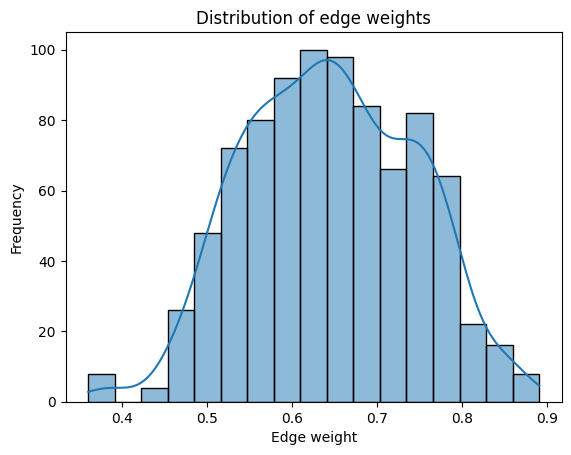

Threshold:  0.5169156972495282
Number of edges:  88


In [194]:
# plot distribution of edge weights

def plot_edge_distribution(distances: List[dict]):
    """Plot the distribution of edge weights.

    Args:
        distances: List[dict]. A list of distances. Each element is a dictionary with the following keys:
            - "id": str. A cluster identifier for the node.
            - "distance": dict. A dictionary of distances to other nodes. The key is the node id and the value is the distance.
    
    Returns:
        None
    """
    
    edge_weights = []
    for distance in distances:
        for key, value in distance["distance"].items():
            edge_weights.append(value)
    
    sns.histplot(edge_weights, kde=True)
    plt.title("Distribution of edge weights")
    plt.xlabel("Edge weight")
    plt.ylabel("Frequency")
    plt.show()

plot_edge_distribution(distances)
# select the lowest quantile of edge weights as threshold
edge_weights = []
for distance in distances:
    for key, value in distance["distance"].items():
        edge_weights.append(value)
threshold = np.quantile(edge_weights, 0.1)
print("Threshold: ", threshold)


# Threshold the distances to get the edges

def threshold_distances(distances: List[dict], threshold: float) -> List[dict]:
    edges = []
    for distance_info in distances:
        current_id = distance_info["id"]
        for other_id, distance in distance_info["distance"].items():
            if distance <= threshold:
                edge = {"source": current_id, "target": other_id, "distance": distance}
                edges.append(edge)
    return edges

edges = threshold_distances(distances, threshold)
print("Number of edges: ", len(edges)) # n x n - n expected from simulation

In [197]:
from pyvis.network import Network
import networkx as nx

def generate_network_from_edges(edges: List[dict]) -> nx.Graph:
    """Generate a network from edges.

    Args:
        edges: List[dict]. A list of edges. Each edge is a dictionary with the following keys:
            - "source": str. The source node id.
            - "target": str. The target node id.
            - "distance": float. The distance between the source and target nodes.
    
    Returns:
        G: nx.Graph. A networkx graph.
    """

    G = nx.Graph()
    for edge in edges:
        source = edge["source"]
        target = edge["target"]
        weight = edge["distance"]
        if source not in G.nodes:
            G.add_node(source)
        if target not in G.nodes:
            G.add_node(target)
        G.add_edge(source, target, weight=1/weight)
    return G


def plot_network(G: nx.Graph, save_path: str = None):
    """Plot the network.

    Args:
        G: nx.Graph. A networkx graph.
        save_path: str. The path to save the plot.
    
    Returns:
        None
    """
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


# normalize edges to [0, 1]
for edge in edges:
    edge["distance"] = (edge["distance"] - min(edge_weights)) / (max(edge_weights) - min(edge_weights))


network = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
nx_graph = generate_network_from_edges(edges)
network.from_nx(nx_graph)


# plot_network(generate_network_from_edges(edges), save_path="network.html")
neighbor_map =network.get_adj_list()
# # add neighbor data to node hover data
# for node in network.nodes:
#     print(node)
#     node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
#     node["value"] = len(neighbor_map[node["id"]])

network.save_graph("network.html")

In [203]:
# Select the best connected node
def select_best_connected_node(edges: List[dict]) -> str:
    """Select the best connected node.

    Args:
        edges: List[dict]. A list of edges. Each edge is a dictionary with the following keys
            - "source": str. The source node id.
            - "target": str. The target node id.
            - "distance": float. The distance between the source and target nodes.
    Returns:
        best_node: str. The best connected node.
    """
    G = generate_network_from_edges(edges)
    best_node = max(G.nodes, key=lambda x: len(list(nx.all_neighbors(G, x))))
    return best_node

best_node = select_best_connected_node(edges)
print("Most connected node: ", best_node)

Most connected node:  sim-consonancia-disc_hernia-004


In [4]:
# Get users in group id on platform with
count = 1
platform_id = "telegram"
users = UserModel.find(
    (UserModel.interaction_count >= count)
    & (UserModel.platform_id == platform_id)
).all()

In [ ]:
        plot_embeddings(
            embeddings_for_clustering, n_components=2, names=list_category_name, perplexity=15, save_path=save_path
        )

        # del list_text
        distances = calculate_distances(nodes, distance_metric="euclidean")

        # Normalize the distances between 0 and 1
        max_distance = max([max(node["distance"].values()) for node in distances])
        for node in distances:
            for neighbor in node["distance"]:
                node["distance"][neighbor] = node["distance"][neighbor] / max_distance

        # plot a distribution of distances

        plt.figure()
        all_distances = [distance for node in distances for distance in node["distance"].values()]
        save_path = f"/Users/eric/Library/CloudStorage/Dropbox/git/github/articulo/conversation_clustering/data/plots/{model_name}_sample_v4_dist.png"
        plt.hist(all_distances, bins=100)
        plt.title(f"Distance distribution for {model_name}")
        plt.savefig(save_path)

        filter = True
        # Get rid of edges with distance greater than 0.3
        if filter:
            threshold = 0.3
            for node in distances:
                node["distance"] = {k: v for k, v in node["distance"].items() if v < threshold}

        G = construct_graph(distances)
        save_path = f"/Users/eric/Library/CloudStorage/Dropbox/git/github/articulo/conversation_clustering/data/plots/{model_name}_sample_v4.html"
        G.write_html(save_path)

In [6]:
# count = 1
# platform_id = "telegram"
# users = UserModel.find(
#     (UserModel.interaction_count >= count)
#     & (UserModel.platform_id == platform_id)
# ).all()

# platform_id = "svaeva-redux"
# group_id = "consonancia"
# conversation_id = "sim-consonancia"
# users = UserModel.find(
#     (UserModel.group_id == group_id)
#     & (UserModel.platform_id == platform_id)
# ).all()
from PIL import Image
import io
import base64
import numpy as np
import cv2

def return_circle_cropped_image_from_user(user: UserModel) -> Image.Image:
    """Return a circle cropped image from a user object
    """
    image = Image.open(io.BytesIO(base64.b64decode(user.avatar_image_bytes)))
    image = np.array(image)
    h, w = image.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (w//2, h//2), int(0.45 * h), 255, -1)
    result = cv2.bitwise_and(image, image, mask=mask)
    image = Image.fromarray(result)
    # make the backgroun transparent
    image = image.convert("RGBA")
    datas = image.getdata()
    new_data = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            new_data.append((255, 255, 255, 0))
        else:
            new_data.append(item)
    image.putdata(new_data)

    return image

users = [UserModel.get("sim-consonancia-pots-001")]
for user in users:
    image = return_circle_cropped_image_from_user(user)
    print(user.avatar_image_prompt)
    image.show()



An art installation symbolizing the journey of a person with POTS, with flickering lights and shadows playing across the room, reflecting the uncertainty, pain, and beauty of their internal experiences. The piece should evoke the feeling of being trapped, yet resilient, symbolizing the universal experience of suffering and endurance. The style should be abstract and immersive, creating a sense of solace, connection, and inspiration.


In [25]:

from PIL import Image

def resize_image(input_image_path, output_image_path):
    """
    Resizes an image to 768x768 pixels.

    Parameters:
    - input_image_path (str): The path to the input image file.
    - output_image_path (str): The path to save the resized image.
    """
    with Image.open(input_image_path) as img:
        # Resize the image
        resized_img = img.resize((768, 768))
        # Save the resized image
        resized_img.save(output_image_path)

# Example usage
input_image_path = "/Users/eric/Library/CloudStorage/Dropbox/git/github/svaeva/svaeva_eric/svaeva-evaluation/data/raw/tmpktqes9xa.png"
output_image_path = "/Users/eric/Library/CloudStorage/Dropbox/git/github/svaeva/svaeva_eric/svaeva-evaluation/data/raw/resized.png"

resize_image(input_image_path, output_image_path)


